Задача: построить модель, которая будет идентифицировать нервные структуры для снимков УЗИ шеи.
Набор данных был взят с соревнования на платформе Kaggle (https://www.kaggle.com/competitions/ultrasound-nerve-segmentation/data).

In [1]:
!pip install segmentation_models_pytorch
! git clone https://github.com/Bjarten/early-stopping-pytorch.git
! mv ./early-stopping-pytorch ./lib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 22.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=54d1a15bb1e4e6222a03904781376360e17024d44c7f7aab67ec3ad84488f836
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=2479f1f17e19da21944a537e0d140f765a307337366031ffd4c17e119fa38346
  Stored in directory: /root/.cache/pip/w

In [2]:
!pip install colour
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 14.8 MB/s eta 0:00:00


In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, sampler
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torchvision
import cv2
import re
import math
# import segmentation_models_pytorch as smp
# from lib.pytorchtools import *

import os
import warnings
from os.path import isfile, join
from typing import Dict, List, Tuple, Union

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from colour import Color
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets, models, transforms 
from tqdm.notebook import trange, tqdm
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

import glob

import PIL
from PIL import Image

warnings.filterwarnings('ignore')

In [4]:
import albumentations as A
import albumentations.pytorch

class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_path, mask_path, transforms):
        self.images = glob.glob(os.path.join(image_path, "*.tif"))
        self.image_path = image_path
        self.mask_path = mask_path
        self.transforms = transforms

    def __getitem__(self, idx):
        img = np.array(Image.open(self.images[idx]).convert("RGB"))
        mask = np.array(
            Image.open(
                os.path.join(
                    self.mask_path,
                    os.path.basename(self.images[idx]).replace(".tif", "_mask.tif"),
                )
            )
        )
        mask[mask == 255.0] = 1.0
        augmentations = self.transforms(image=img, mask=mask)
        image = augmentations["image"]
        mask = augmentations["mask"]
        mask = torch.unsqueeze(mask, 0)
        mask = mask.type(torch.float32)
        return image, mask

    def __len__(self):
        return len(self.images)

In [5]:
data = SegmentationDataset(
    image_path="/content/drive/MyDrive/Ultrasound_Nerve_Segmentation/train_folder",
    mask_path="/content/drive/MyDrive/Ultrasound_Nerve_Segmentation/masks_folder",
    transforms=
    A.Compose(
        [
            # albumentations.augmentations.geometric.rotate.Rotate(),
            # A.augmentations.geometric.rotate.Rotate(limit = 20, p = 0.7),
            A.Resize(height=256, width=256), 
            A.pytorch.transforms.ToTensorV2()]
    ),
)

train_size = 0.85
train_len = math.floor(len(data) * train_size)
val_len = len(data) - train_len
train_dataset, val_dataset = torch.utils.data.random_split(data, [train_len, val_len])

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=3
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=3
)

In [6]:
len(data)

5635

In [7]:
print(data[0][0].shape)
data[0][0]

torch.Size([3, 256, 256])


tensor([[[ 35,  58,  71,  ...,  97,  98, 101],
         [ 76,  98, 112,  ..., 139, 134, 140],
         [ 91, 132, 129,  ...,  96,  95, 100],
         ...,
         [ 48,  79,  78,  ...,  38,  40,  42],
         [ 41,  67,  67,  ...,  43,  44,  44],
         [ 39,  53,  55,  ...,  48,  48,  47]],

        [[ 35,  58,  71,  ...,  97,  98, 101],
         [ 76,  98, 112,  ..., 139, 134, 140],
         [ 91, 132, 129,  ...,  96,  95, 100],
         ...,
         [ 48,  79,  78,  ...,  38,  40,  42],
         [ 41,  67,  67,  ...,  43,  44,  44],
         [ 39,  53,  55,  ...,  48,  48,  47]],

        [[ 35,  58,  71,  ...,  97,  98, 101],
         [ 76,  98, 112,  ..., 139, 134, 140],
         [ 91, 132, 129,  ...,  96,  95, 100],
         ...,
         [ 48,  79,  78,  ...,  38,  40,  42],
         [ 41,  67,  67,  ...,  43,  44,  44],
         [ 39,  53,  55,  ...,  48,  48,  47]]], dtype=torch.uint8)

In [8]:
plt.rcParams.update({
    'figure.facecolor': 'black'
})

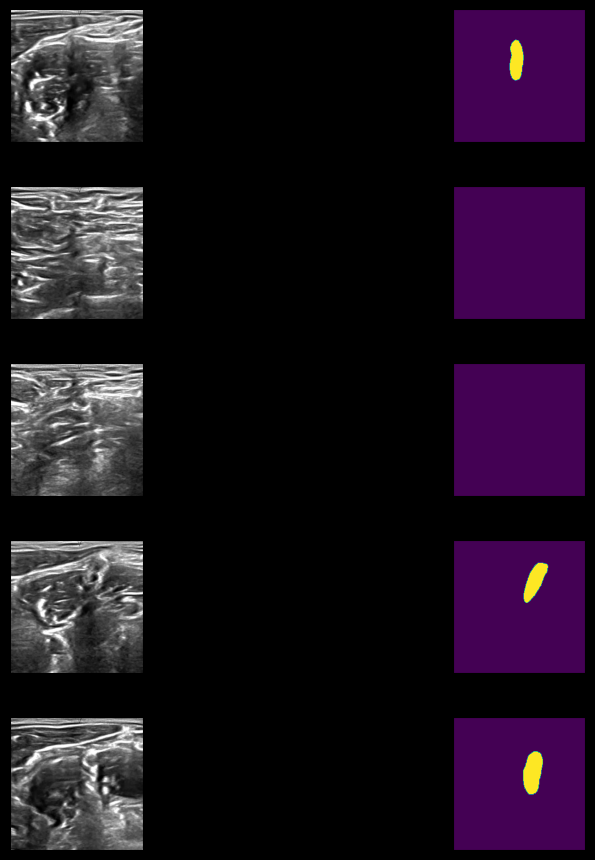

In [112]:
def im_show(img_list: List[Tuple[str, str]]) -> None:
    """
    Plots images with correspinding segmentation mask

    :param img_list: list of paths to images
    """
    to_PIL = transforms.ToPILImage()
    
    fig, axes = plt.subplots(len(img_list), 2, figsize=(9, 9))
    fig.tight_layout()

    for (idx, sample) in enumerate(img_list):
        a = axes[idx][0].imshow(np.array(to_PIL(sample[0])))
        b = axes[idx][1].imshow(np.array(to_PIL(sample[1])))
        for ax in axes[idx]:
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

img_list = []
for i in range(5):
    img, label = train_dataset[np.random.randint(0, 50)]
    img_list.append((img, label))

im_show(img_list)

In [69]:
class ConvBlock(pl.LightningModule):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(pl.LightningModule):
    def __init__(
        self,
        in_channels: int = 3,
        out_channels: int = 1,
        features: List[int] = [32, 64, 128],
        # learning_rate: float = 1.5e-3,
    ):
        super().__init__()
        # self.learning_rate = learning_rate
        self.down = nn.ModuleList()
        self.up = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)  # Phase change
        for feature in features:
            self.down.append(ConvBlock(in_channels=in_channels, out_channels=feature))
            in_channels = feature
        for feature in reversed(features):
            self.up.append(
                nn.ConvTranspose2d(
                    in_channels=feature * 2,
                    out_channels=feature,
                    kernel_size=2,
                    stride=2,
                )
            )
            self.up.append(
                ConvBlock(
                    in_channels=feature * 2, out_channels=feature
                )  # x gets concat to 2xchannel
            )
        self.bottleneck = ConvBlock(
            in_channels=features[-1], out_channels=features[-1] * 2
        )
        self.final_conv = nn.Conv2d(
            in_channels=features[0], out_channels=out_channels, kernel_size=1
        )
        self.loss_fn = nn.BCEWithLogitsLoss()
        # self.loss_fn = smp.losses.DiceLoss()
        self.optimizer = torch.optim.Adam(
            self.parameters(), lr = 0.001#, weight_decay=0.3
        )

        self.val_num_correct = 0
        self.val_num_pixels = 0
        self.val_dice_score = 0
        self.num_correct = 0
        self.num_pixels = 0
        self.dice_score = 0

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        skip_connections = []  # storage for skip connections
        for down in self.down:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]  # reverse list
        for idx in range(0, len(self.up), 2):
            x = self.up[idx](x)
            skip_connection = skip_connections[idx // 2]
            if x.shape != skip_connection.shape:
                x = transforms.functional.resize(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat(
                (skip_connection, x), dim=1
            )  # Concat along channels dimensions (b, c, h, w)
            x = self.up[idx + 1](concat_skip)
        return self.final_conv(x)

    def configure_optimizers(self):
        return self.optimizer
    
    def training_step(self, batch: torch.Tensor, batch_idx) -> Dict[str, torch.Tensor]:
        x, y = batch
        pred = self(x.float())
        loss = self.loss_fn(pred, y)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float()
        self.num_correct += (pred == y).sum()
        self.num_pixels += torch.numel(pred)
        self.dice_score += (2 * (pred * y).sum()) / ((pred + y).sum() + 1e-8)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def on_training_epoch_end(self, output: List[Dict[str, torch.Tensor]]):
        train_acc = float(f"{(self.num_correct/self.num_pixels)*100:.2f}")
        self.log("train_acc", train_acc, prog_bar=True)
        dice_score = self.dice_score / len(output)
        self.log("train_dice_score", dice_score, prog_bar=True)
        self.num_correct, self.num_pixels, self.dice_score = 0, 0, 0

    def validation_step(
        self, batch: torch.Tensor, batch_idx: int
    ) -> Dict[str, torch.Tensor]:
        x, y = batch
        pred = self(x.float())
        loss = self.loss_fn(pred, y)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float()
        self.val_num_correct += (pred == y).sum()
        self.val_num_pixels += torch.numel(pred)
        self.val_dice_score += (2 * (pred * y).sum()) / ((pred + y).sum() + 1e-8)
        self.log("val_loss", loss, prog_bar=True)
        return {"loss": loss}

    def on_validation_epoch_end(self):#, output: List[Dict[str, torch.Tensor]]):
        val_acc = float(f"{(self.val_num_correct / self.val_num_pixels) * 100:.2f}")
        self.log("val_acc", val_acc, prog_bar=True)
        # dice_score = self.val_dice_score / len(output)
        # self.log("val_dice_score", dice_score, prog_bar=True)
        self.val_num_correct, self.val_num_pixels, self.val_dice_score = 0, 0, 0
        # self.validation_step_outputs.clear()

    # def training_step(self, batch: torch.Tensor, batch_idx) -> Dict[str, torch.Tensor]:
    #     x, y = batch
    #     pred = self(x.float())
    #     loss = self.loss_fn(pred, y)
    #     pred = torch.sigmoid(pred)
    #     pred = (pred > 0.5).float()
    #     self.num_correct += (pred == y).sum()
    #     self.num_pixels += torch.numel(pred)
    #     self.dice_score += (2 * (pred * y).sum()) / ((pred + y).sum() + 1e-8)
    #     self.log("train_loss", loss, prog_bar=True)
    #     return {"loss": loss}

    # def on_training_epoch_end(self, output: List[Dict[str, torch.Tensor]]):
    #     train_acc = float(f"{(self.num_correct/self.num_pixels)*100:.2f}")
    #     self.log("train_acc", train_acc, prog_bar=True)
    #     dice_score = self.dice_score / len(output)
    #     self.log("train_dice_score", dice_score, prog_bar=True)
    #     self.num_correct, self.num_pixels, self.dice_score = 0, 0, 0

    # def validation_step(
    #     self, batch: torch.Tensor, batch_idx: int
    # ) -> Dict[str, torch.Tensor]:
    #     x, y = batch
    #     pred = self(x.float())
    #     loss = self.loss_fn(pred, y)
    #     pred = torch.sigmoid(pred)
    #     pred = (pred > 0.5).float()
    #     self.val_num_correct += (pred == y).sum()
    #     self.val_num_pixels += torch.numel(pred)
    #     self.val_dice_score += (2 * (pred * y).sum()) / ((pred + y).sum() + 1e-8)
    #     self.log("val_loss", loss, prog_bar=True)
    #     return {"loss": loss}

    # def on_validation_epoch_end(self, output: List[Dict[str, torch.Tensor]]):
    #     val_acc = float(f"{(self.val_num_correct / self.val_num_pixels) * 100:.2f}")
    #     self.log("val_acc", val_acc, prog_bar=True)
    #     dice_score = self.val_dice_score / len(output)
    #     self.log("val_dice_score", dice_score, prog_bar=True)
    #     self.val_num_correct, self.val_num_pixels, self.val_dice_score = 0, 0, 0

In [70]:
pl.utilities.model_summary.summarize(UNET(), -1)

   | Name              | Type              | Params
---------------------------------------------------------
0  | down              | ModuleList        | 287 K 
1  | down.0            | ConvBlock         | 10.2 K
2  | down.0.conv       | Sequential        | 10.2 K
3  | down.0.conv.0     | Conv2d            | 864   
4  | down.0.conv.1     | BatchNorm2d       | 64    
5  | down.0.conv.2     | ReLU              | 0     
6  | down.0.conv.3     | Conv2d            | 9.2 K 
7  | down.0.conv.4     | BatchNorm2d       | 64    
8  | down.0.conv.5     | ReLU              | 0     
9  | down.1            | ConvBlock         | 55.6 K
10 | down.1.conv       | Sequential        | 55.6 K
11 | down.1.conv.0     | Conv2d            | 18.4 K
12 | down.1.conv.1     | BatchNorm2d       | 128   
13 | down.1.conv.2     | ReLU              | 0     
14 | down.1.conv.3     | Conv2d            | 36.9 K
15 | down.1.conv.4     | BatchNorm2d       | 128   
16 | down.1.conv.5     | ReLU              | 0     
17 | d

In [64]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [71]:
# model.eval()

UNET(
  (down): ModuleList(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (2): ConvBlock(
      (conv): Seq

In [72]:
torch.cuda.empty_cache()
model = UNET()
# model.to(device)

In [73]:
model.to(device)

UNET(
  (down): ModuleList(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (2): ConvBlock(
      (conv): Seq

In [74]:
from pytorch_lightning.callbacks import EarlyStopping

early_stopping_callback  = EarlyStopping(monitor = 'val_acc', patience = 3)

trainer = pl.Trainer(
    max_epochs = 20,
    accelerator = 'gpu',
    devices = 1,
    # auto_lr_find = True,
    callbacks = [early_stopping_callback]
)

trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params
-------------------------------------------------
0 | down       | ModuleList        | 287 K 
1 | up         | ModuleList        | 753 K 
2 | pool       | MaxPool2d         | 0     
3 | bottleneck | ConvBlock         | 885 K 
4 | final_conv | Conv2d            | 33    
5 | loss_fn    | BCEWithLogitsLoss | 0     
-------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.708     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [76]:
# model.learning_rate

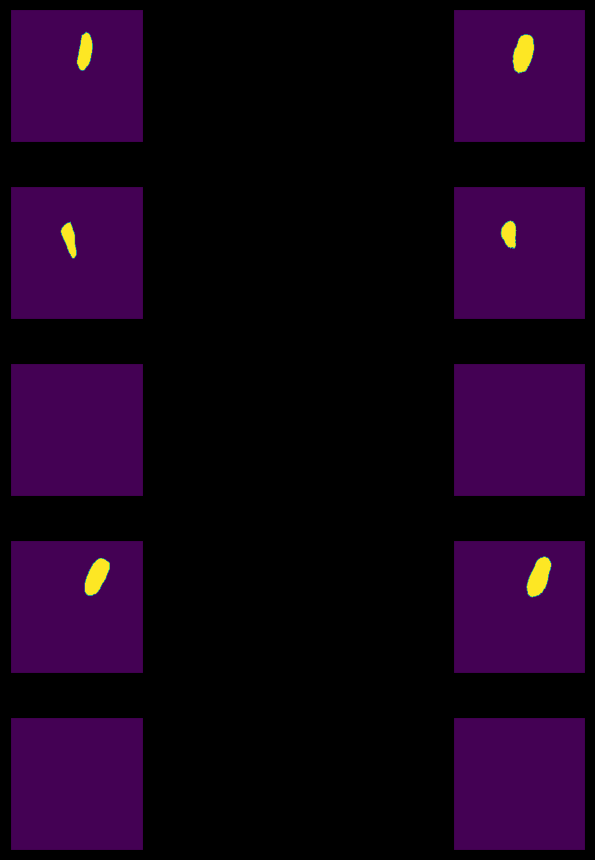

In [77]:
def mask_to_image(mask: np.ndarray):
    if mask.ndim == 2:
        return np.array((mask * 255).astype(np.uint8))
    elif mask.ndim == 3:
        return np.array(
            (np.argmax(mask, axis=0) * 255 / mask.shape[0]).astype(np.uint8)
        )


def predict_img(net, img, device, out_threshold=0.5):
    net.eval()
    net.to(device)

    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)

        probs = torch.sigmoid(output)
        full_mask = probs.cpu().squeeze()

        return (full_mask > out_threshold).numpy()


img_list = []

for i in range(5):    
    img_base, img = val_dataset[np.random.randint(0, 100)]
    mask = predict_img(model, img_base, device="cuda")
    result = mask_to_image(mask)
    img_list.append((img, result))
    
im_show(img_list)

In [79]:
# ex_3 = predict_img(model, test_data[3], device = 'cpu')
# result = mask_to_image(ex_3)
# ex_3

In [ ]:
len(img_list)

9

In [80]:
import torchvision

class SegmentationTestDataset(torch.utils.data.Dataset):
    def __init__(self, image_path, transforms):
        self.images = glob.glob(os.path.join(image_path, "*.tif"))
        self.image_path = image_path
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getpath__(self):
        return self.images

    def __getitem__(self, idx):
        img = np.array(Image.open(self.images[idx]).convert("RGB"))
        augmentations = self.transforms(image=img)
        image = augmentations["image"]
        # image = torchvision.transforms.functional.to_tensor(image)
        return image

test_data = SegmentationTestDataset(
    image_path = '/content/drive/MyDrive/Ultrasound_Nerve_Segmentation/test_folder',
    transforms = A.Compose(
        [A.Resize(height=256, width=256), A.pytorch.transforms.ToTensorV2()]
    )
)

In [81]:
test_data.__getpath__()[0:2]

['/content/drive/MyDrive/Ultrasound_Nerve_Segmentation/test_folder/5066.tif',
 '/content/drive/MyDrive/Ultrasound_Nerve_Segmentation/test_folder/5054.tif']

In [82]:
test_data[0], train_dataset[0][0], val_dataset[0][0]

(tensor([[[ 72, 105,  99,  ..., 128, 135, 135],
          [117, 164, 154,  ..., 203, 193, 203],
          [134, 176, 165,  ..., 180, 173, 180],
          ...,
          [ 13,  15,   8,  ...,  10,   9,   9],
          [ 12,  16,   8,  ...,  19,  20,  21],
          [ 12,  15,  12,  ...,  36,  38,  38]],
 
         [[ 72, 105,  99,  ..., 128, 135, 135],
          [117, 164, 154,  ..., 203, 193, 203],
          [134, 176, 165,  ..., 180, 173, 180],
          ...,
          [ 13,  15,   8,  ...,  10,   9,   9],
          [ 12,  16,   8,  ...,  19,  20,  21],
          [ 12,  15,  12,  ...,  36,  38,  38]],
 
         [[ 72, 105,  99,  ..., 128, 135, 135],
          [117, 164, 154,  ..., 203, 193, 203],
          [134, 176, 165,  ..., 180, 173, 180],
          ...,
          [ 13,  15,   8,  ...,  10,   9,   9],
          [ 12,  16,   8,  ...,  19,  20,  21],
          [ 12,  15,  12,  ...,  36,  38,  38]]], dtype=torch.uint8),
 tensor([[[108, 152, 166,  ..., 101,  92,  85],
          [161,

In [83]:
test_data[0].shape

torch.Size([3, 256, 256])

In [84]:
train_dataset[0][0].shape, test_data[0][0].shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

In [85]:
train_dataset[0][0][0].shape, test_data[0][0].shape

(torch.Size([256, 256]), torch.Size([256, 256]))

In [86]:
test_data[0][0]

tensor([[ 72, 105,  99,  ..., 128, 135, 135],
        [117, 164, 154,  ..., 203, 193, 203],
        [134, 176, 165,  ..., 180, 173, 180],
        ...,
        [ 13,  15,   8,  ...,  10,   9,   9],
        [ 12,  16,   8,  ...,  19,  20,  21],
        [ 12,  15,  12,  ...,  36,  38,  38]], dtype=torch.uint8)

In [87]:
test_data[0]

tensor([[[ 72, 105,  99,  ..., 128, 135, 135],
         [117, 164, 154,  ..., 203, 193, 203],
         [134, 176, 165,  ..., 180, 173, 180],
         ...,
         [ 13,  15,   8,  ...,  10,   9,   9],
         [ 12,  16,   8,  ...,  19,  20,  21],
         [ 12,  15,  12,  ...,  36,  38,  38]],

        [[ 72, 105,  99,  ..., 128, 135, 135],
         [117, 164, 154,  ..., 203, 193, 203],
         [134, 176, 165,  ..., 180, 173, 180],
         ...,
         [ 13,  15,   8,  ...,  10,   9,   9],
         [ 12,  16,   8,  ...,  19,  20,  21],
         [ 12,  15,  12,  ...,  36,  38,  38]],

        [[ 72, 105,  99,  ..., 128, 135, 135],
         [117, 164, 154,  ..., 203, 193, 203],
         [134, 176, 165,  ..., 180, 173, 180],
         ...,
         [ 13,  15,   8,  ...,  10,   9,   9],
         [ 12,  16,   8,  ...,  19,  20,  21],
         [ 12,  15,  12,  ...,  36,  38,  38]]], dtype=torch.uint8)

In [88]:
test_data[0].shape

torch.Size([3, 256, 256])

In [89]:
train_dataset[1][1].shape

torch.Size([1, 256, 256])

In [90]:
# model.to(device)

# test_pred = trainer.predict(model, test_loader)

In [ ]:
# predictions[0][0].unsqueeze(0).squeeze(0).shape

torch.Size([1, 256, 256])

In [ ]:
# RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [ ]:
len(val_dataset[2][1].flatten().unique())

val_mask_list = []

for i in range(10):
    if len(val_dataset[i][1].flatten().unique()) > 1:
        print(i)
        val_mask_list.append(i)

3
5
6
7
9


In [ ]:
for i in [1, 2, 3, 4]:
    print(i)

1
2
3
4


In [ ]:
val_dataset[3][1].flatten().unique()

tensor([0., 1.])

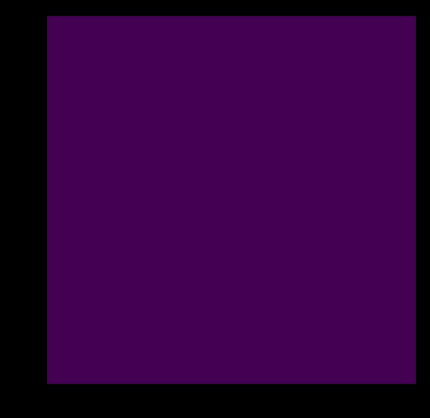

In [95]:
import torchvision.transforms as T

pred_transform = T.ToPILImage()
for i in range(3, 4):
    pred_tensor = val_dataset[i][1].permute(0, 1, 2)
    pred_image = pred_transform(pred_tensor)
    plt.imshow(pred_image)

In [93]:
val_dataset[3][1].permute(0, 1, 2).shape

torch.Size([1, 256, 256])

In [94]:
test_data[3].permute(0, 1, 2).shape

torch.Size([3, 256, 256])

In [ ]:
val_dataset[3][0].shape, val_dataset[3][1].permute(0, 1, 2).shape

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

In [92]:
## predict test set
path2 = '/content/drive/MyDrive/Ultrasound_Nerve_Segmentation/test_folder'
image_dataset = os.listdir(path2)
test_img = []
for file in image_dataset:
    test_img.append(file)

In [ ]:
test_img

['5066.tif',
 '5054.tif',
 '5060.tif',
 '5065.tif',
 '5062.tif',
 '5063.tif',
 '5058.tif',
 '5064.tif',
 '5061.tif',
 '5072.tif',
 '5067.tif',
 '5055.tif',
 '5070.tif',
 '5068.tif',
 '5057.tif',
 '506.tif',
 '5056.tif',
 '507.tif',
 '5069.tif',
 '5091.tif',
 '5078.tif',
 '5082.tif',
 '5080.tif',
 '5088.tif',
 '508.tif',
 '5087.tif',
 '5086.tif',
 '509.tif',
 '5076.tif',
 '5073.tif',
 '5083.tif',
 '5084.tif',
 '5079.tif',
 '5075.tif',
 '5074.tif',
 '5077.tif',
 '5092.tif',
 '5085.tif',
 '5089.tif',
 '5090.tif',
 '5081.tif',
 '51.tif',
 '5099.tif',
 '510.tif',
 '511.tif',
 '5096.tif',
 '5110.tif',
 '5102.tif',
 '5100.tif',
 '5103.tif',
 '5111.tif',
 '5108.tif',
 '5101.tif',
 '5105.tif',
 '5104.tif',
 '5095.tif',
 '5107.tif',
 '5098.tif',
 '5093.tif',
 '5109.tif',
 '5097.tif',
 '5106.tif',
 '5094.tif',
 '5127.tif',
 '5112.tif',
 '5121.tif',
 '5117.tif',
 '5133.tif',
 '5120.tif',
 '5115.tif',
 '5124.tif',
 '5113.tif',
 '5126.tif',
 '5129.tif',
 '5132.tif',
 '5131.tif',
 '5125.tif',
 '5118.

In [ ]:
type(test_img)

list

In [ ]:
s = ['1.tif', '3.tif', '2.tif']
s = [int(i.replace('.tif', '')) for i in s]
print(sorted(s))
s = sorted(s)
s = [str(i) for i in s]
print(s)
s = [(i+'.tif') for i in s]
print(s)

[1, 2, 3]
['1', '2', '3']
['1.tif', '2.tif', '3.tif']


In [98]:
def mask_to_image(mask: np.ndarray):
    if mask.ndim == 2:
        return np.array((mask * 255).astype(np.uint8))
    elif mask.ndim == 3:
        return np.array(
            (np.argmax(mask, axis=0) * 255 / mask.shape[0]).astype(np.uint8)
        )


def predict_img(net, img, device, out_threshold=0.5):
    net.eval()
    net.to(device)

    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)

        probs = torch.sigmoid(output)
        full_mask = probs.cpu().squeeze()

        return (full_mask > out_threshold).numpy()

ex_3 = predict_img(model, test_data[3], device = 'cpu')
result = mask_to_image(ex_3)
ex_3

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [107]:
result

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

  0%|          | 0/5508 [00:00<?, ?it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 <matplotlib.image.AxesImage at 0x7f0ddf4e02e0>)

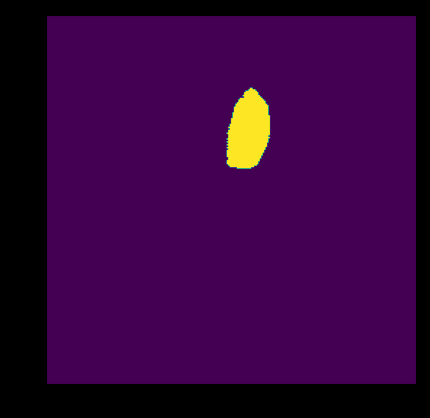

In [99]:
predictions = []
for i in tqdm(test_data):
    pred_img = predict_img(model, i, device = 'cuda')
    prediction = mask_to_image(pred_img)
    predictions.append(prediction)

predictions[0], plt.imshow(predictions[0])

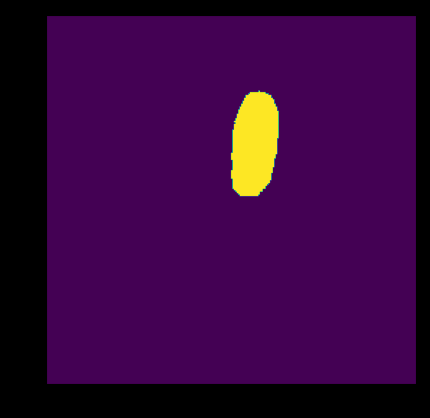

In [106]:
plt.imshow(predictions[8])

In [ ]:
# val_dataset[3][0], test_data[3], train_dataset[3]

(tensor([[[ 86, 129, 127,  ..., 124, 124, 123],
          [138, 191, 190,  ..., 202, 198, 196],
          [102, 147, 146,  ..., 161, 158, 163],
          ...,
          [ 26,  29,  29,  ...,   5,   4,   3],
          [ 26,  36,  34,  ...,   3,   4,   5],
          [ 33,  49,  48,  ...,   3,   5,   6]],
 
         [[ 86, 129, 127,  ..., 124, 124, 123],
          [138, 191, 190,  ..., 202, 198, 196],
          [102, 147, 146,  ..., 161, 158, 163],
          ...,
          [ 26,  29,  29,  ...,   5,   4,   3],
          [ 26,  36,  34,  ...,   3,   4,   5],
          [ 33,  49,  48,  ...,   3,   5,   6]],
 
         [[ 86, 129, 127,  ..., 124, 124, 123],
          [138, 191, 190,  ..., 202, 198, 196],
          [102, 147, 146,  ..., 161, 158, 163],
          ...,
          [ 26,  29,  29,  ...,   5,   4,   3],
          [ 26,  36,  34,  ...,   3,   4,   5],
          [ 33,  49,  48,  ...,   3,   5,   6]]], dtype=torch.uint8),
 tensor([[[127, 182, 182,  ..., 169, 164, 148],
          [161,

In [ ]:
print(predictions[0].squeeze(0).permute(2, 1, 0).shape)
predictions[0].squeeze(0)

torch.Size([256, 256, 1])


tensor([[[-4.8574, -4.5091, -4.4366,  ..., -4.4548, -4.5169, -4.6217],
         [-4.8388, -5.0216, -5.0548,  ..., -5.1148, -5.1324, -4.7968],
         [-4.6351, -4.8736, -4.9144,  ..., -5.0334, -5.0873, -4.7805],
         ...,
         [-4.6293, -4.8887, -4.9655,  ..., -4.9870, -5.0832, -4.7791],
         [-4.6850, -4.9430, -5.0192,  ..., -5.0624, -5.1070, -4.7815],
         [-4.9030, -4.7956, -4.8844,  ..., -4.9001, -4.9191, -4.7325]]])

In [ ]:
print(test_X[0].shape)
test_X[0]

(256, 256, 3)


array([[[0.2734375 , 0.2734375 , 0.2734375 ],
        [0.44140625, 0.44140625, 0.44140625],
        [0.40234375, 0.40234375, 0.40234375],
        ...,
        [0.5234375 , 0.5234375 , 0.5234375 ],
        [0.55078125, 0.55078125, 0.55078125],
        [0.55078125, 0.55078125, 0.55078125]],

       [[0.421875  , 0.421875  , 0.421875  ],
        [0.64453125, 0.64453125, 0.64453125],
        [0.5859375 , 0.5859375 , 0.5859375 ],
        ...,
        [0.765625  , 0.765625  , 0.765625  ],
        [0.7421875 , 0.7421875 , 0.7421875 ],
        [0.76953125, 0.76953125, 0.76953125]],

       [[0.48828125, 0.48828125, 0.48828125],
        [0.72265625, 0.72265625, 0.72265625],
        [0.65234375, 0.65234375, 0.65234375],
        ...,
        [0.70703125, 0.70703125, 0.70703125],
        [0.6796875 , 0.6796875 , 0.6796875 ],
        [0.703125  , 0.703125  , 0.703125  ]],

       ...,

       [[0.046875  , 0.046875  , 0.046875  ],
        [0.05859375, 0.05859375, 0.05859375],
        [0.03125   , 0

In [ ]:
test_img

['5066.tif',
 '5054.tif',
 '5060.tif',
 '5065.tif',
 '5062.tif',
 '5063.tif',
 '5058.tif',
 '5064.tif',
 '5061.tif',
 '5072.tif',
 '5067.tif',
 '5055.tif',
 '5070.tif',
 '5068.tif',
 '5057.tif',
 '506.tif',
 '5056.tif',
 '507.tif',
 '5069.tif',
 '5091.tif',
 '5078.tif',
 '5082.tif',
 '5080.tif',
 '5088.tif',
 '508.tif',
 '5087.tif',
 '5086.tif',
 '509.tif',
 '5076.tif',
 '5073.tif',
 '5083.tif',
 '5084.tif',
 '5079.tif',
 '5075.tif',
 '5074.tif',
 '5077.tif',
 '5092.tif',
 '5085.tif',
 '5089.tif',
 '5090.tif',
 '5081.tif',
 '51.tif',
 '5099.tif',
 '510.tif',
 '511.tif',
 '5096.tif',
 '5110.tif',
 '5102.tif',
 '5100.tif',
 '5103.tif',
 '5111.tif',
 '5108.tif',
 '5101.tif',
 '5105.tif',
 '5104.tif',
 '5095.tif',
 '5107.tif',
 '5098.tif',
 '5093.tif',
 '5109.tif',
 '5097.tif',
 '5106.tif',
 '5094.tif',
 '5127.tif',
 '5112.tif',
 '5121.tif',
 '5117.tif',
 '5133.tif',
 '5120.tif',
 '5115.tif',
 '5124.tif',
 '5113.tif',
 '5126.tif',
 '5129.tif',
 '5132.tif',
 '5131.tif',
 '5125.tif',
 '5118.

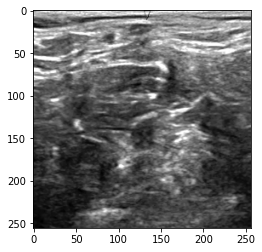

In [ ]:
# test_dataset[0][0]

import torchvision.transforms as T

pred_transform = T.ToPILImage()
for i in range(0, 1):
    pred_tensor = test_data[0].permute(0, 1, 2)
    pred_image = pred_transform(pred_tensor)
    plt.imshow(pred_image)

In [ ]:
test_img[24][:-4]

'508'